# План симуляций
0. Превышение критической энергии, условие  возникновения лавины.
1. Симуляции паратметров электронной лавины без учета гамма-квантов
2. Расчет длинны нарастания лавины для разных высот и полей (делая поправку для поля на высоту)
3. Расчет средней энергии электронов, спектра электронов, зависимости от начальной энергии




In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tables
import matplotlib as mpl

In [5]:
path = "/home/zelenyy/data/thunderstorm/test/result.hdf5"

In [6]:
with tables.open_file(path) as h5file:
    # print(h5file)
    for group in h5file.root:
        table = h5file.get_node(group, "stacking_simple")
        print(repr(table.attrs))
        data = table.read()
        break

/sim0001/stacking_simple._v_attrs (AttributeSet), 36 attributes:
   [CLASS := 'TABLE',
    FIELD_0_FILL := 0,
    FIELD_0_NAME := 'event',
    FIELD_1_FILL := 0,
    FIELD_1_NAME := 'id',
    FIELD_2_FILL := 0,
    FIELD_2_NAME := 'parent_id',
    FIELD_3_FILL := 0,
    FIELD_3_NAME := 'particle',
    FIELD_4_FILL := 0.0,
    FIELD_4_NAME := 'energy',
    FIELD_5_FILL := 0.0,
    FIELD_5_NAME := 'theta',
    FIELD_6_FILL := 0.0,
    FIELD_6_NAME := 'radius',
    FIELD_7_FILL := 0.0,
    FIELD_7_NAME := 'z',
    FIELD_8_FILL := 0.0,
    FIELD_8_NAME := 'time',
    NROWS := 1069,
    TITLE := '',
    VERSION := '2.7',
    path := 'sim0001',
    text := '/npm/geometry/type gdml\n/npm/geometry/gdml .././gdml/0.gdml\n/npm/thunderstorm/physics standard_opt_4\n/npm/thunderstorm/cut/energy 0.05\n/npm/thunderstorm/stacking/electron false\n/npm/thunderstorm/stacking/positron false\n/npm/thunderstorm/stacking/gamma false\n/npm/thunderstorm/stacking/save_gamma true\n/npm/thunderstorm/stacking/save

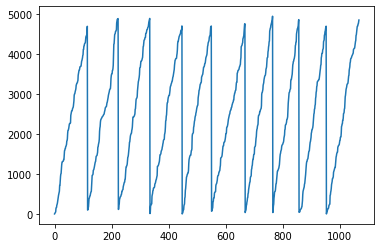

In [7]:
plt.plot(data["id"])

In [8]:
data["id"]



array([   6,   18,   32, ..., 4765, 4821, 4860], dtype=int32)